Authors: Marcin Biedrzycki <s13448@pjwstk.edu.pl>, Tomasz Sosiński <s16216@pjwstk.edu.pl>

Problem: Train AI to play bowling game

Followed by: github user @deepanshut041

# install os dependencies to display env

In [ ]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet


Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-2build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.5).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import python dependencies

In [ ]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import math

%matplotlib inline

# start virtual display

In [ ]:
from pyvirtualdisplay import Display
Display().start()


#import ai classes

In [ ]:
import sys
from agent import A2CAgent
from models import ActorCnn, CriticCnn
from stack_frame import preprocess_frame, stack_frame

# create environment

In [ ]:
%pip install -U gym>=0.21.0
%pip install gym[atari]

%pip install gym[atari,accept-rom-license]==0.21.0
env = gym.make('Bowling-v0')
env.seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ale_py-0.8.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.7.5
    Uninstalling ale-py-0.7.5:
      Successfully uninstalled ale-py-0.7.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached gym-0.21.0-py3-none-any.whl
  Using cached ale_py-0.7.5-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Attempting uninstall: gym
    Found existing installation: gym 0.26.2
    Uninstalling gym-0.26.2:
      Successfully uninstalled gym-0.26.2
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.8.0
    Uninstalling ale-py-0.8.0:
      Successfully uninstalled ale-py-0.8.0


(2968811710, 3677149159)

# set accelerator 

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


# view Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


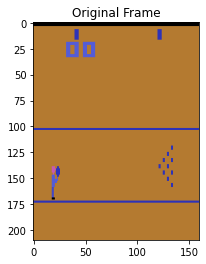

In [ ]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### execute the code cell below to play with a random policy.

In [ ]:
def random_play():
    score = 0
    env.reset()
    while True:
        env.render(mode='rgb_array')
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            print("Your Score at end of game is: ", score)
            break
random_play()

Your Score at end of game is:  10.0




```
# Sformatowano jako kod
```

# preprocessing frame

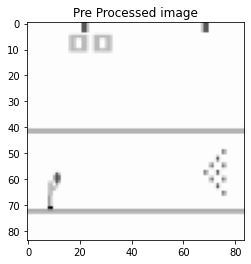

In [ ]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

# stacking frame

In [ ]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames
    

# creating agent

In [ ]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
ALPHA= 0.0001          # Actor learning rate
BETA = 0.0005          # Critic learning rate
UPDATE_EVERY = 100     # how often to update the network 

agent = A2CAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, GAMMA, ALPHA, BETA, UPDATE_EVERY, ActorCnn, CriticCnn)

# run untrained agent play

In [ ]:

state = stack_frames(None, env.reset(), True) 
for j in range(200):
    env.render(mode='rgb_array')
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
        
env.close()

# loading agent
Uncomment line to load a pretrained agent

In [ ]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

# train the agent with DQN

In [ ]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        while True:
            action, log_prob, entropy = agent.act(state)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, log_prob, entropy, reward, done, next_state)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    
    return scores

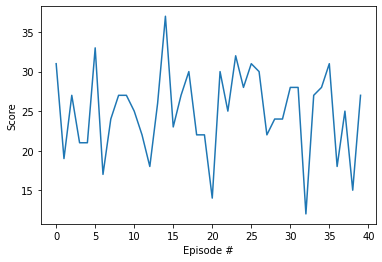

Episode 40	Average Score: 24.95

In [ ]:
scores = train(1000)

# run learnt agent

In [ ]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render(mode='rgb_array')
    action, _, _ = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()